In [ ]:
import os
import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, Huber
from statsmodels.tsa.arima.model import ARIMA
import joblib

# **Data pre-processing**

In [ ]:
# Read the CSV files
deposit_rate_df = pd.read_csv("/content/Deposit rate.csv", parse_dates=["Date"], dayfirst=False)
gbp_exchange_rates_df = pd.read_csv("/content/GBP_ExchangeRates_Daily.csv", parse_dates=["Date"], dayfirst=False)

# Convert both date columns to a consistent format (YYYY-MM-DD)
deposit_rate_df["Date"] = pd.to_datetime(deposit_rate_df["Date"]).dt.strftime("%Y-%m-%d")
gbp_exchange_rates_df["Date"] = pd.to_datetime(gbp_exchange_rates_df["Date"]).dt.strftime("%Y-%m-%d")

# Merge datasets on the 'Date' column
merged_df = pd.merge(deposit_rate_df, gbp_exchange_rates_df, on="Date", how="inner")
# Display the first few rows of the merged dataset
print(merged_df.head())
merged_df = merged_df.dropna()
print(merged_df.shape)
merged_df.tail()

         Date  Deposit rate  GBP_EUR  GBP_USD  GBP_HKD  GBP_JPY
0  2015-01-01          0.48   1.2875   1.5586  12.0859  186.630
1  2015-01-02          0.53   1.2772   1.5328  11.8890  184.698
2  2015-01-05          0.53   1.2779   1.5250  11.8271  182.437
3  2015-01-06          0.53   1.2743   1.5151  11.7488  179.374
4  2015-01-07          0.53   1.2763   1.5110  11.7181  180.201
(2380, 6)


,Date,Deposit rate,GBP_EUR,GBP_USD,GBP_HKD,GBP_JPY
2378,2024-02-13,5.23,1.1760,1.2592,9.8466,189.906
2379,2024-02-14,5.24,1.1713,1.2566,9.8249,189.219
2380,2024-02-15,5.24,1.1696,1.2600,9.8526,188.911
2381,2024-02-16,5.24,1.1692,1.2602,9.8559,189.269
2382,2024-02-19,5.24,1.1686,1.2594,9.8512,189.090


In [ ]:
plot_df = merged_df.copy()

# Ensure the 'Date' column is in datetime format
plot_df['Date'] = pd.to_datetime(plot_df['Date'])

# plot_df.set_index('Date', inplace=True)

# Sort the data by date
plot_df = plot_df.sort_values(by='Date')

plot_df.head()

,Date,Deposit rate,GBP_EUR,GBP_USD,GBP_HKD,GBP_JPY
0,2015-01-01,0.48,1.2875,1.5586,12.0859,186.630
1,2015-01-02,0.53,1.2772,1.5328,11.8890,184.698
2,2015-01-05,0.53,1.2779,1.5250,11.8271,182.437
3,2015-01-06,0.53,1.2743,1.5151,11.7488,179.374
4,2015-01-07,0.53,1.2763,1.5110,11.7181,180.201


# **Visualization**

In [ ]:
print(plot_df.columns)


Index(['Date', 'Deposit rate', 'GBP_EUR', 'GBP_USD', 'GBP_HKD', 'GBP_JPY'], dtype='object')


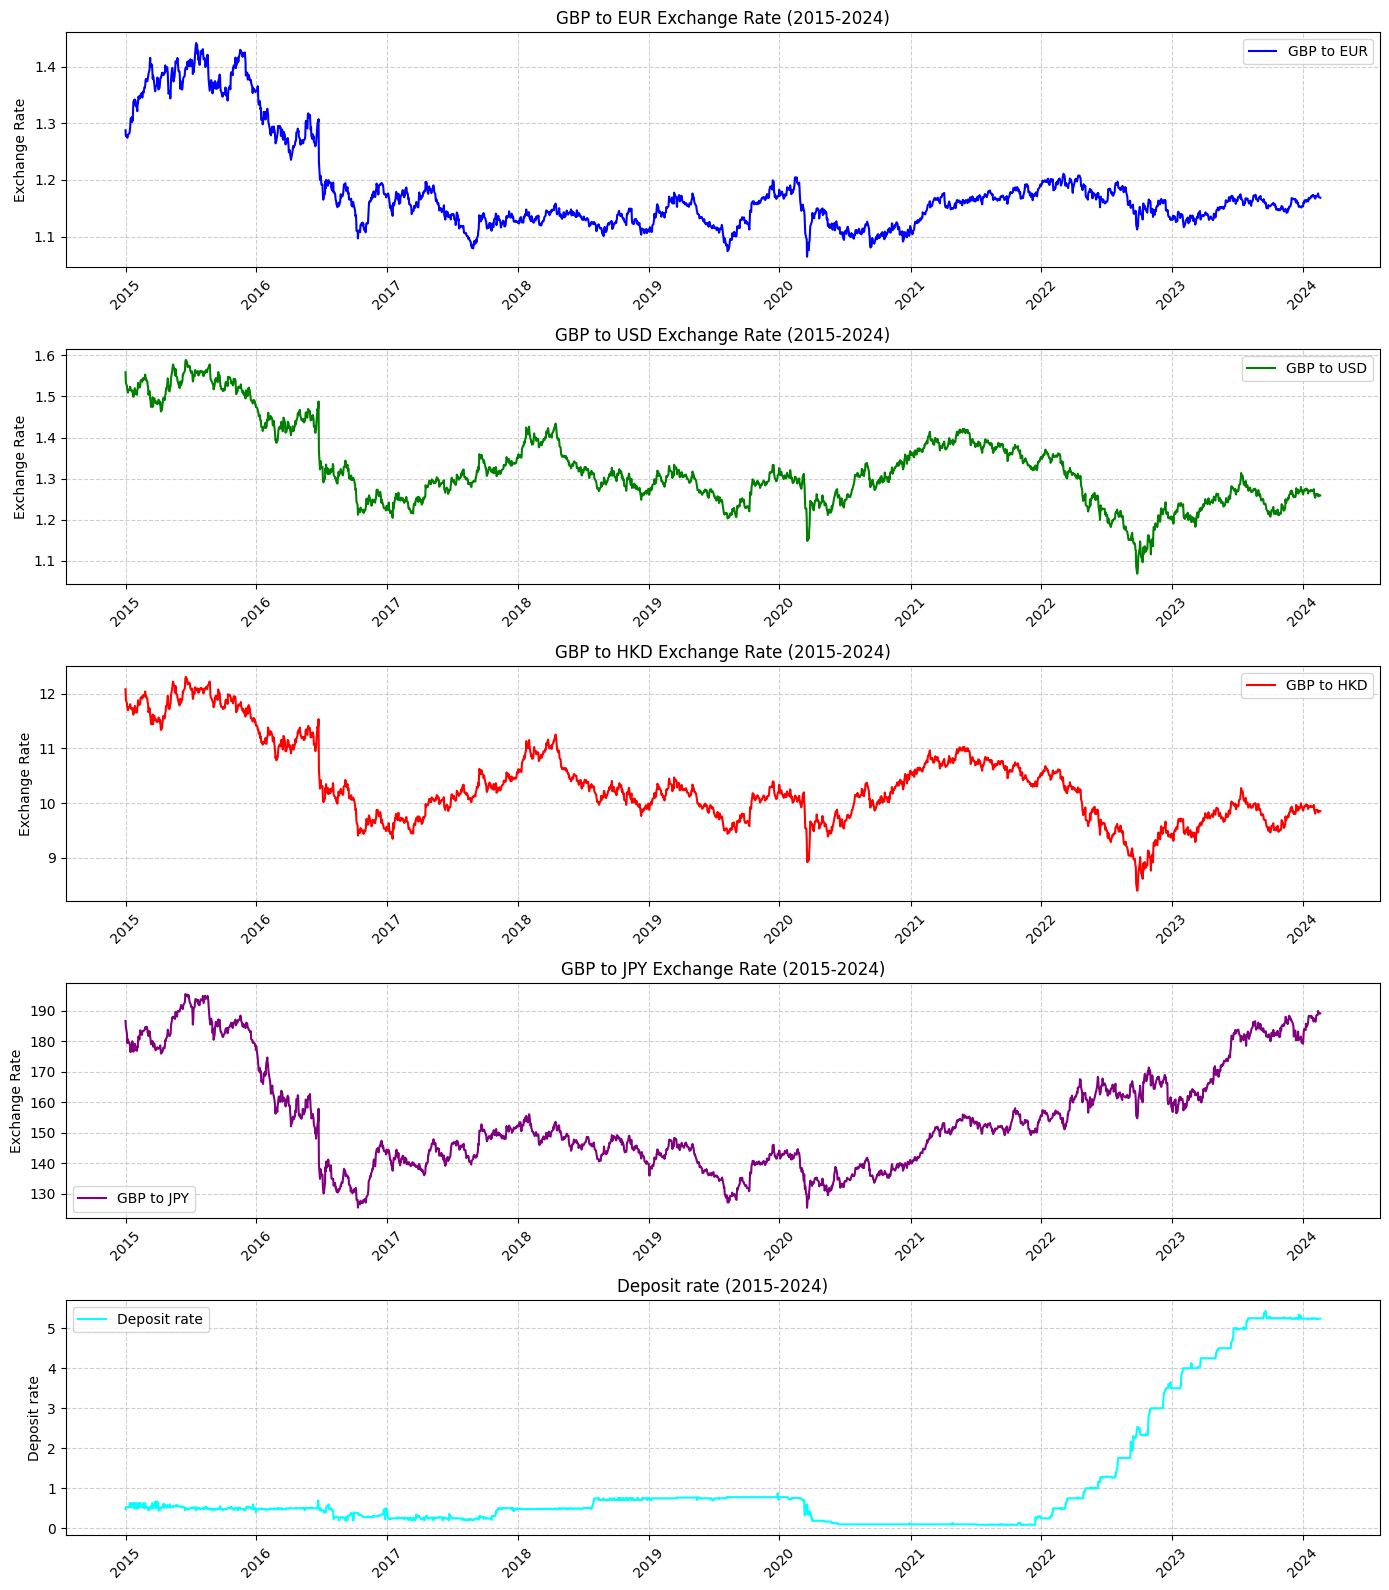

In [ ]:
# Create subplots for each currency pair
fig, axes = plt.subplots(5, 1, figsize=(14, 16))

# Plot GBP to EUR
axes[0].plot(plot_df['Date'], plot_df['GBP_EUR'], label='GBP to EUR', color='blue')
axes[0].set_title('GBP to EUR Exchange Rate (2015-2024)')
axes[0].set_ylabel('Exchange Rate')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot GBP to USD
axes[1].plot(plot_df['Date'], plot_df['GBP_USD'], label='GBP to USD', color='green')
axes[1].set_title('GBP to USD Exchange Rate (2015-2024)')
axes[1].set_ylabel('Exchange Rate')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot GBP to HKD
axes[2].plot(plot_df['Date'], plot_df['GBP_HKD'], label='GBP to HKD', color='red')
axes[2].set_title('GBP to HKD Exchange Rate (2015-2024)')
axes[2].set_ylabel('Exchange Rate')
axes[2].legend()
axes[2].grid(True, linestyle='--', alpha=0.6)

# Plot GBP to JPY
axes[3].plot(plot_df['Date'], plot_df['GBP_JPY'], label='GBP to JPY', color='purple')
axes[3].set_title('GBP to JPY Exchange Rate (2015-2024)')
axes[3].set_ylabel('Exchange Rate')
axes[3].legend()
axes[3].grid(True, linestyle='--', alpha=0.6)

axes[4].plot(plot_df['Date'], plot_df['Deposit rate'], label='Deposit rate', color='cyan')
axes[4].set_title('Deposit rate (2015-2024)')
axes[4].set_ylabel('Deposit rate')
axes[4].legend()
axes[4].grid(True, linestyle='--', alpha=0.6)

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()



---



# **LSTM model**

Training model for GBP_EUR...
Epoch 1/50


<ipython-input-13-275fe026c69b>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0347 - val_loss: 0.1166
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0292 - val_loss: 0.1150
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0285 - val_loss: 0.1146
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0289 - val_loss: 0.1157
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0291 - val_loss: 0.1149
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0287 - val_loss: 0.1152
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0272 - val_loss: 0.1144
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0287 - val_loss: 0.1143
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0279 - val_loss: 0.1164
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0285 - val_loss: 0.1155
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0272 - val_loss: 0.1145
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/s

Model for GBP_EUR saved successfully. MSE: 0.00506, R2: 0.14923


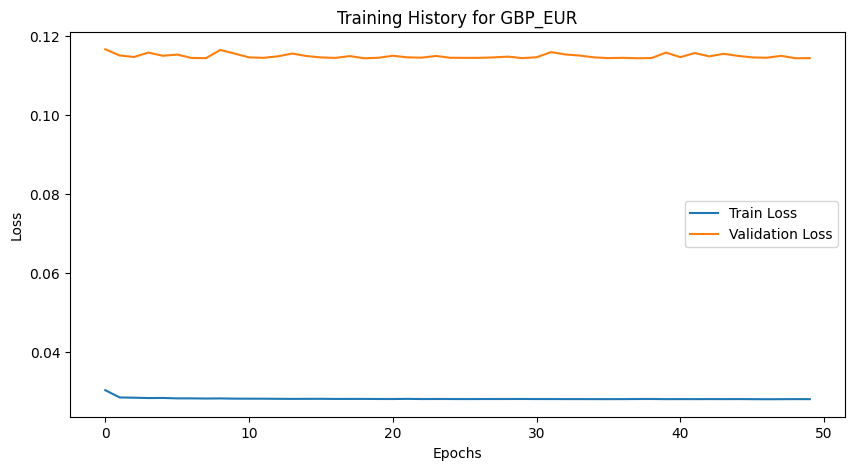

Training model for GBP_USD...


<ipython-input-13-275fe026c69b>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0656 - val_loss: 0.0809
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0580 - val_loss: 0.0852
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0570 - val_loss: 0.0808
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0586 - val_loss: 0.0815
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0564 - val_loss: 0.0804
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0570 - val_loss: 0.0806
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0577 - val_loss: 0.0808
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0566 - val_loss: 0.0806
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0577 - val_loss: 0.0808
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0580 - val_loss: 0.0812
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0561 - val_loss: 0.0805
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━

Model for GBP_USD saved successfully. MSE: 0.01505, R2: -0.72333


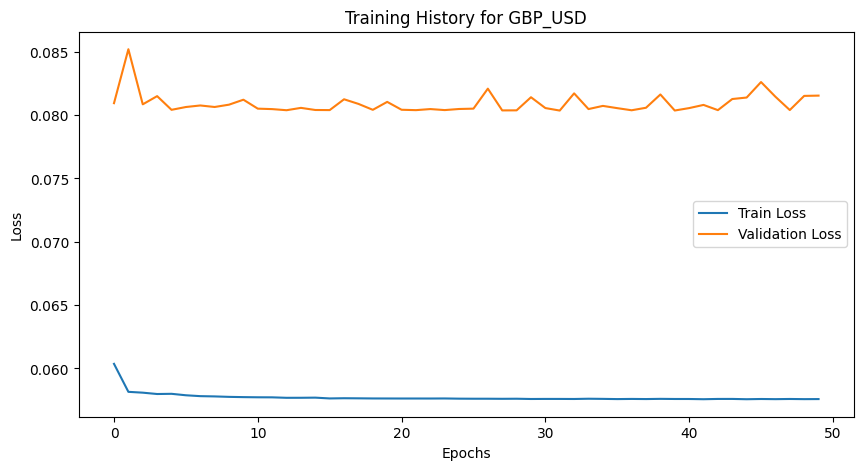

<ipython-input-13-275fe026c69b>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model for GBP_HKD...
Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0672 - val_loss: 0.0789
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0588 - val_loss: 0.0792
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0577 - val_loss: 0.0818
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0573 - val_loss: 0.0788
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0574 - val_loss: 0.0793
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0574 - val_loss: 0.0792
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0565 - val_loss: 0.0794
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0568 - val_loss: 0.0791
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0576 - val_loss: 0.0795
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0582 - val_loss: 0.0796
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0582 - val_loss: 0.0788
Epoch 12/5

Model for GBP_HKD saved successfully. MSE: 0.96832, R2: -0.95049


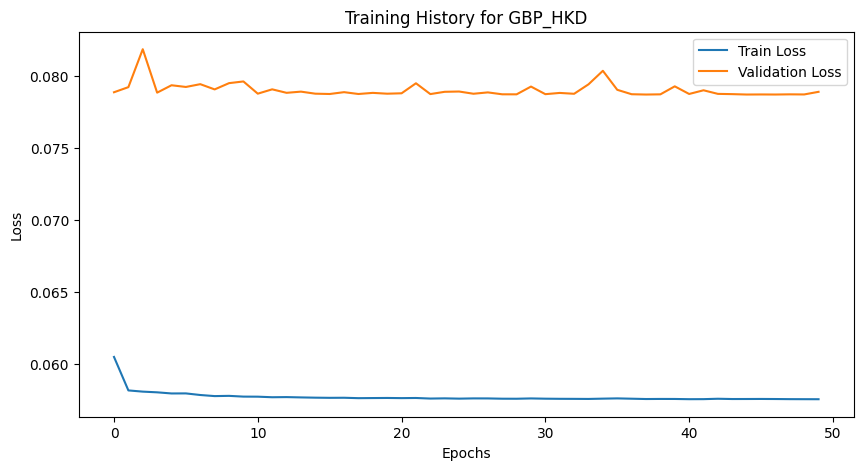

Training model for GBP_JPY...


<ipython-input-13-275fe026c69b>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0357 - val_loss: 0.0096
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0317 - val_loss: 0.0102
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0304 - val_loss: 0.0056
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0322 - val_loss: 0.0054
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0307 - val_loss: 0.0053
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0322 - val_loss: 0.0071
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0317 - val_loss: 0.0051
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0304 - val_loss: 0.0084
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0321 - val_loss: 0.0050
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0317 - val_loss: 0.0054
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0296 - val_loss: 0.0051
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━

Model for GBP_JPY saved successfully. MSE: 127.02794, R2: 0.55844


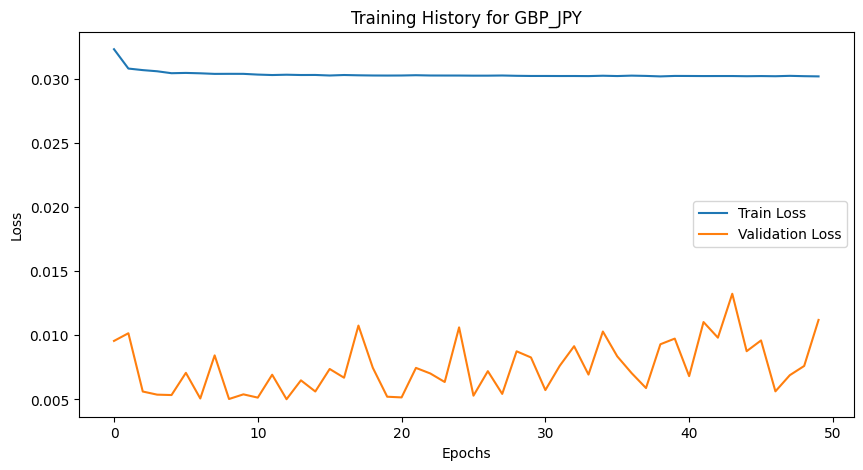

Training Results: {'GBP_EUR': {'MSE': 0.005064069214653139, 'R2': 0.1492323735033637}, 'GBP_USD': {'MSE': 0.015053796331325106, 'R2': -0.7233310105165358}, 'GBP_HKD': {'MSE': 0.9683219773538555, 'R2': -0.95048849188564}, 'GBP_JPY': {'MSE': 127.02793936245705, 'R2': 0.5584410213564139}}


In [ ]:
def prepare_data(currency, window_size=60):
    """Load and preprocess currency data."""
    data = plot_df.copy()
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data.fillna(method='ffill', inplace=True)  # Forward fill missing values

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[[currency, 'Deposit rate']])
    os.makedirs('models2', exist_ok=True)
    joblib.dump(scaler, f'models2/scaler_{currency}.pkl')

    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i + window_size])
        y.append(scaled_data[i + window_size])

    return np.array(X), np.array(y), scaler, data

def train_and_save_models(window_size=60, epochs=50, batch_size=16):
    """Train LSTM models for all currencies and save the best ones based on R2 score and MSE."""
    currencies = ['GBP_EUR', 'GBP_USD', 'GBP_HKD', 'GBP_JPY']
    results = {}

    for currency in currencies:
        print(f"Training model for {currency}...")
        X, y, scaler, data = prepare_data(currency, window_size)

        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=(window_size, 2)),
            Dropout(0.2),
            LSTM(100, return_sequences=False),
            Dropout(0.2),
            Dense(50, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')
        history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1)

        y_pred = model.predict(X)
        # Create dummy array for inverse_transform
        dummy_pred = np.zeros((len(y_pred), 2))
        dummy_actual = np.zeros((len(y), 2))

        # Put predictions and actuals into the correct column (currency column = 0)
        dummy_pred[:, 0] = y_pred[:, 0]
        dummy_actual[:, 0] = y[:, 0]

        # Inverse transform
        y_pred_inv = scaler.inverse_transform(dummy_pred)[:, 0]  # only take the currency back
        y_actual_inv = scaler.inverse_transform(dummy_actual)[:, 0]


        mse = mean_squared_error(y_actual_inv, y_pred_inv)
        r2 = r2_score(y_actual_inv, y_pred_inv)

        results[currency] = {'MSE': mse, 'R2': r2}

        model.save(f'models2/model_{currency}.h5')
        print(f"Model for {currency} saved successfully. MSE: {mse:.5f}, R2: {r2:.5f}")

        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training History for {currency}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return results


if __name__ == "__main__":
    results = train_and_save_models()
    print("Training Results:", results)


In [ ]:
def load_model_and_predict(currency, start_date=None, end_date=None, window_size=60):
    """Load LSTM model and predict future currency rates using deposit rate as input feature."""
    custom_objects = {"mse": MeanSquaredError()}
    model = load_model(f'models2/model_{currency}.h5', custom_objects=custom_objects)
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

    scaler = joblib.load(f'models2/scaler_{currency}.pkl')

    data = plot_df.copy()
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    if start_date is None or end_date is None:
        start_date = datetime.date.today()
        end_date = start_date + datetime.timedelta(days=7)
    else:
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

    # Extract both features
    last_window = data[[currency, 'Deposit rate']].iloc[-window_size:].values
    last_window = scaler.transform(last_window)

    predictions = []
    current_window = last_window
    future_dates = pd.date_range(start=start_date, end=end_date)

    # ARIMA only on the currency
    arima_model = ARIMA(data[currency].dropna(), order=(2, 1, 2)).fit()

    for date in future_dates:
        pred_scaled = model.predict(current_window.reshape(1, window_size, 2))

        # Prepare dummy for inverse transform
        dummy = np.zeros((1, 2))
        dummy[0, 0] = pred_scaled[0, 0]  # Currency in column 0

        pred_value = scaler.inverse_transform(dummy)[0, 0]

        # Adjust with ARIMA-based fluctuations
        arima_forecast = arima_model.forecast(steps=1).iloc[0]
        pred_value = (pred_value + arima_forecast) / 2

        predictions.append((date, round(pred_value, 3)))

        # Assume deposit rate stays constant (or you could extrapolate)
        last_deposit_rate = current_window[-1, 1]
        new_input = np.array([[pred_scaled[0, 0], last_deposit_rate]])
        current_window = np.append(current_window[1:], new_input, axis=0)

    # Plot actual vs predicted
    plt.figure(figsize=(12, 5))
    plt.plot(data.index[-100:], data[currency].values[-100:], label='Historical Data', color='blue')
    plt.plot([p[0] for p in predictions], [p[1] for p in predictions], label='Predicted Data', color='red', linestyle='dashed')
    plt.title(f'{currency} - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Currency Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return predictions


In [ ]:
def user_input():
    currency = input("Enter the currency (GBP_EUR, GBP_USD, GBP_HKD, GBP_JPY): ")
    start_date = input("Enter the start date (YYYY-MM-DD) or press Enter for default: ")
    end_date = input("Enter the end date (YYYY-MM-DD) or press Enter for default: ")

    start_date = start_date if start_date else None
    end_date = end_date if end_date else None

    predicted_rates = load_model_and_predict(currency, start_date, end_date)
    print(f"\nPredicted rates for {currency} from {start_date} to {end_date}:\n")
    for date, rate in predicted_rates:
        print(f"{date}: {rate}")

Enter the currency (GBP_EUR, GBP_USD, GBP_HKD, GBP_JPY): GBP_JPY
Enter the start date (YYYY-MM-DD) or press Enter for default: 
Enter the end date (YYYY-MM-DD) or press Enter for default: 


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


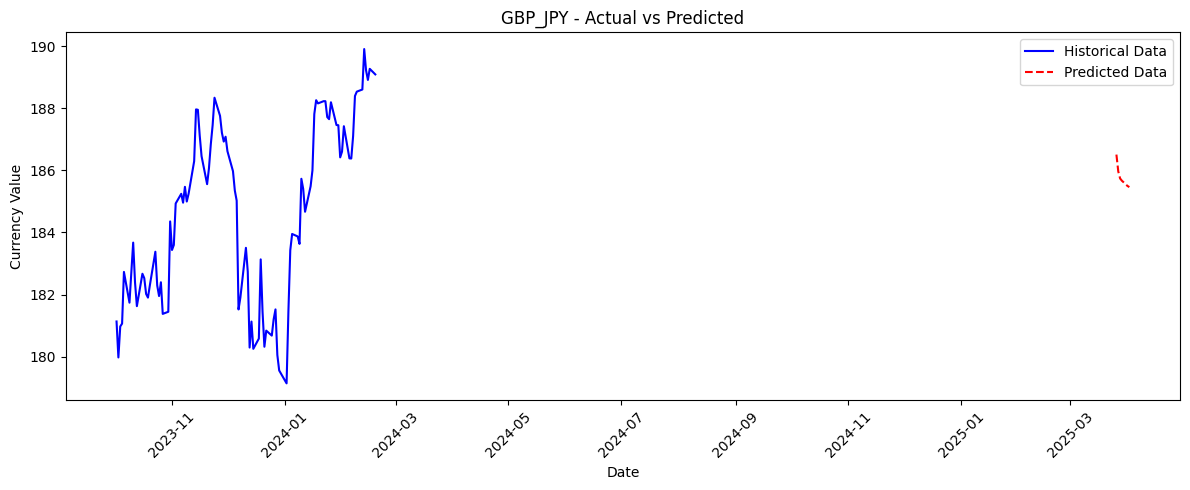


Predicted rates for GBP_JPY from None to None:

2025-03-26 00:00:00: 186.508
2025-03-27 00:00:00: 185.966
2025-03-28 00:00:00: 185.738
2025-03-29 00:00:00: 185.664
2025-03-30 00:00:00: 185.61
2025-03-31 00:00:00: 185.55
2025-04-01 00:00:00: 185.498
2025-04-02 00:00:00: 185.46


In [ ]:
user_input()

# **Comparison of ARIMA, Random forest and LSTM**

In [ ]:
def evaluate_models_on_currency(currency, window_size=60):
    """Train ARIMA and Random Forest models, and compare them with LSTM using Deposit Rate."""
    print(f"\nEvaluating {currency}...")

    data = plot_df.copy()
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data.fillna(method='ffill', inplace=True)

    values = data[[currency, 'Deposit rate']].dropna()

    # --- LSTM Model Evaluation ---
    scaler = joblib.load(f'models2/scaler_{currency}.pkl')
    X_lstm, y_lstm = [], []

    scaled_values = scaler.transform(values)

    for i in range(window_size, len(scaled_values)):
        X_lstm.append(scaled_values[i - window_size:i])
        y_lstm.append(scaled_values[i][0])  # Only the currency value is the target

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm).reshape(-1, 1)

    model_lstm = load_model(f'models2/model_{currency}.h5', custom_objects={"mse": MeanSquaredError()})
    model_lstm.compile(optimizer='adam', loss='mse')
    lstm_pred_scaled = model_lstm.predict(X_lstm)

    # Create dummy arrays for inverse transform
    dummy_pred = np.zeros((len(lstm_pred_scaled), 2))
    dummy_actual = np.zeros((len(y_lstm), 2))

    dummy_pred[:, 0] = lstm_pred_scaled[:, 0]
    dummy_actual[:, 0] = y_lstm[:, 0]

    lstm_pred = scaler.inverse_transform(dummy_pred)[:, 0]
    y_lstm_actual = scaler.inverse_transform(dummy_actual)[:, 0]

    lstm_mse = mean_squared_error(y_lstm_actual, lstm_pred)
    lstm_r2 = r2_score(y_lstm_actual, lstm_pred)

    # --- ARIMA Model Evaluation ---
    values_currency = values[[currency]]
    train_arima = values_currency.iloc[:-30]
    test_arima = values_currency.iloc[-30:]

    arima_model = ARIMA(train_arima, order=(2, 1, 2)).fit()
    arima_forecast = arima_model.forecast(steps=len(test_arima))
    arima_mse = mean_squared_error(test_arima.values, arima_forecast.values)
    arima_r2 = r2_score(test_arima.values, arima_forecast.values)

    # --- Random Forest Model Evaluation ---
    df_rf = values.copy()
    for i in range(1, window_size + 1):
        df_rf[f'{currency}_lag_{i}'] = df_rf[currency].shift(i)
        df_rf[f'depositrate_lag_{i}'] = df_rf['Deposit rate'].shift(i)

    df_rf.dropna(inplace=True)

    X_rf = df_rf.drop(columns=[currency, 'Deposit rate']).values
    y_rf = df_rf[currency].values

    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, shuffle=False)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_rf, y_train_rf)
    rf_pred = rf_model.predict(X_test_rf)

    rf_mse = mean_squared_error(y_test_rf, rf_pred)
    rf_r2 = r2_score(y_test_rf, rf_pred)

    return {
        'Currency': currency,
        'LSTM_MSE': lstm_mse,
        'LSTM_R2': lstm_r2,
        'ARIMA_MSE': arima_mse,
        'ARIMA_R2': arima_r2,
        'RF_MSE': rf_mse,
        'RF_R2': rf_r2
    }


In [ ]:
def compare_all_models():
    currencies = ['GBP_EUR', 'GBP_USD', 'GBP_HKD', 'GBP_JPY']
    results = []

    for currency in currencies:
        result = evaluate_models_on_currency(currency)
        results.append(result)

    df_results = pd.DataFrame(results)
    print("\nModel Comparison Results:\n")
    print(df_results)
    return df_results



In [ ]:
comparison_df = compare_all_models()



Evaluating GBP_EUR...


<ipython-input-34-445b494d502e>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u


Evaluating GBP_USD...
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


Evaluating GBP_HKD...
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u


Evaluating GBP_JPY...
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


Model Comparison Results:

  Currency    LSTM_MSE   LSTM_R2  ARIMA_MSE  ARIMA_R2    RF_MSE     RF_R2
0  GBP_EUR    0.005064  0.149232   0.000035 -1.413241  0.000023  0.915098
1  GBP_USD    0.015054 -0.723331   0.000103 -1.835983  0.000465  0.752016
2  GBP_HKD    0.968322 -0.950488   0.004342 -1.036052  0.018284  0.832624
3  GBP_JPY  127.027939  0.558441  14.774703 -5.990084  2.225292  0.978425
